# Hate Speech Detector 2.0
---
**Statistical data analysis**
1. Yearly counts analysis (pie plot)
2. Monthly, weekdaily and hourly count analysis. (bar plot)
3. Timeline tweet counts analysis. (line plot)
4. Hate speech types analysis:
    1. Monthly, weekdaily and hourly count analysis of certain hate type analysis. (bar plot)
    2. Timeline tweet counts of certain hate type analysis. (line plot)

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
MONTH_NAMES = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
WEEKDAY_NAMES = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [3]:
pd.set_option('display.max_colwidth', 400)

In [4]:
plt.style.use('ggplot')

In [5]:
def daterange(start, end):
    for n in range(int((end-start).days)):
        yield start + timedelta(n)

## Data loading
---

In [6]:
def get_stats(df, hate_type=None, month_names=None, weekday_names=None):
    all_years = np.unique(list([d.split('-')[0] for d in df['date']]))
    all_months = range(1, 13)
    all_weekdays = range(7)
    all_hours = range(24)
    all_dates = list(daterange(datetime.strptime(df['date'].iloc[0], '%Y-%m-%d'),
                               datetime.strptime(df['date'].iloc[-1], '%Y-%m-%d')))
    
    if hate_type:
        df = df[df[hate_type] == 1.0][['date', 'time']]
    
    # yearly counts dataframe
    df_yc = pd.DataFrame({'year': all_years})
    y = list([d.split('-')[0] for d in df['date']])
    y, cnt = np.unique(y, return_counts=True)
    df_yc = df_yc.merge(pd.DataFrame({
        'year': y,
        'count': cnt
    }), left_on='year', right_on='year', how='left')
    df_yc = df_yc.set_index('year')
    
    # monthly counts
    df_mc = pd.DataFrame({'month': all_months})
    m = np.array([int(d.split('-')[1]) for d in df['date']])
    m, cnt = np.unique(m, return_counts=True)
    df_mc = df_mc.merge(pd.DataFrame({
        'month': m,
        'count': cnt
    }), left_on='month', right_on='month', how='left')
    if month_names:
        df_mc['month'] = df_mc['month'].map(dict(zip(range(1, 13), month_names)))
    df_mc = df_mc.set_index('month')
    
    # weekdaily counts
    df_wdc = pd.DataFrame({'weekday': all_weekdays})
    wd = np.array([datetime.strptime(d, '%Y-%m-%d').weekday() for d in df['date']])
    wd, cnt = np.unique(wd, return_counts=True)
    df_wdc = df_wdc.merge(pd.DataFrame({
        'weekday': wd,
        'count': cnt
    }), left_on='weekday', right_on='weekday', how='left')
    if weekday_names:
        df_wdc['weekday'] = df_wdc['weekday'].map(dict(zip(range(7), weekday_names)))
    df_wdc = df_wdc.set_index('weekday')
    
    # hourly counts
    df_hc = pd.DataFrame({'hour': all_hours})
    h = np.array([int(t.split(':')[0]) for t in df['time']])
    h, cnt = np.unique(h, return_counts=True)
    df_hc = df_hc.merge(pd.DataFrame({
        'hour': h,
        'count': cnt
    }), left_on='hour', right_on='hour', how='left')
    df_hc['hour'] = list([f'             {h}' for h in df_hc['hour'].values])
    df_hc = df_hc.set_index('hour')
    
    # daily (by date) counts
    df_dc = pd.DataFrame({'date': all_dates})
    d, cnt = np.unique(df['date'].values, return_counts=True)
    df_dc = df_dc.merge(pd.DataFrame({
        'date': list([datetime.strptime(dt, '%Y-%m-%d') for dt in d]),
        'count': cnt
    }), left_on='date', right_on='date', how='left')
    df_dc = df_dc.set_index('date')
    
    return df_yc, df_mc, df_wdc, df_hc, df_dc

In [7]:
df_combined = pd.read_csv('data/tweets_sady/main/sady_combined.csv')
df_combined.head(2)

,id,date,time,user_id,username,name,tweet,emojis,emoticons,mentions,...,likes_count,wydźwięk,klucze,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,2014-06-06,21:41:42,2367137142,krzysztofcicho3,Krzysztof Cichosz,Dokładnie! Dlatego trzeba komuchów gonić przed sądy póki żyją. I mięć otwarte oczy na komuchów zakamuflowanych,NaN,NaN,['tomsokolewicz'],...,0,-1,komuchów; gonić komuchów,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-06-06,18:58:53,780543464,zalewski53,Roland Zalewski,Polska Polityka: Sądy bardziej bezkarne niż w PRL,NaN,NaN,[],...,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dates = df_combined['date'].values
dates

array(['2014-06-06', '2014-06-06', '2014-06-06', ..., '2016-11-12',
       '2016-11-12', '2016-11-12'], dtype=object)

In [9]:
times = df_combined['time'].values
times

array(['21:41:42', '18:58:53', '18:52:58', ..., '15:43:14', '11:30:36',
       '08:59:37'], dtype=object)

In [10]:
years = np.array([int(d.split('-')[0]) for d in dates])
years

array([2014, 2014, 2014, ..., 2016, 2016, 2016])

In [11]:
months = np.array([int(d.split('-')[1]) for d in dates])
months

array([ 6,  6,  6, ..., 11, 11, 11])

In [12]:
weekdays = np.array([datetime.strptime(d, '%Y-%m-%d').weekday() for d in dates])
weekdays

array([4, 4, 4, ..., 5, 5, 5])

In [13]:
hours = np.array([int(t.split(':')[0]) for t in times])
hours

array([21, 18, 18, ..., 15, 11,  8])

In [14]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined,
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

## Yearly counts analysis
---

In [15]:
df_yc

,count
year,
2014,2286
2015,6676
2016,6240


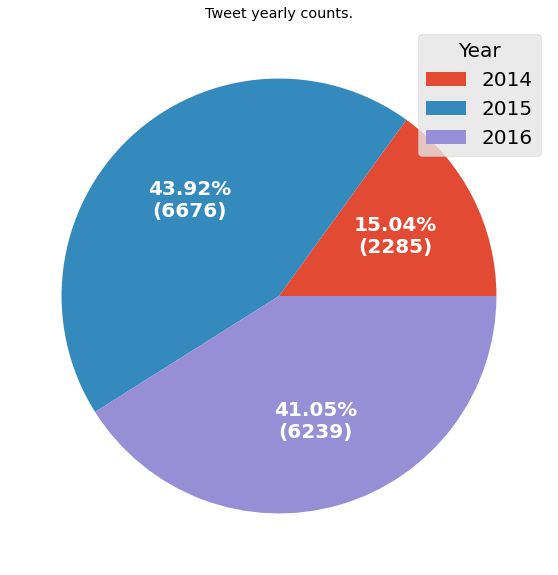

In [16]:
def tweet_yearly_counts_pie(df, show_legend=True, title='Tweet yearly counts.'):
    fig, ax = plt.subplots(figsize=(16, 10))
    
    data = df['count'].values
    labels = df.index.values


    def annotate(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return f'{pct:.2f}%\n({absolute:d})'

    t_props = {'color': 'w', 'fontsize': 20, 'weight': 'bold'}
    l_props = {'size': 20}


    wedges, _, _ = ax.pie(data, autopct=lambda pct: annotate(pct, data), textprops=t_props)
    
    if show_legend:
        leg = ax.legend(wedges, labels, loc="upper right", fontsize=20)
        leg.set_title("Year", prop=l_props)

    ax.set_title(title)

    plt.show()
    
tweet_yearly_counts_pie(df_yc)

## Monthly, weekdaily, hourly counts
---

In [17]:
df_mc

,count
month,
January,1073
February,988
March,631
April,333
May,103
June,826
July,1528
August,1709
September,2162


In [18]:
df_wdc

,count
weekday,
Monday,2323
Tuesday,2472
Wednesday,2664
Thursday,2396
Friday,2122
Saturday,1633
Sunday,1592


In [19]:
df_hc

,count
hour,
0,325
1,153
2,78
3,35
4,35
5,41
6,123
7,322
8,637


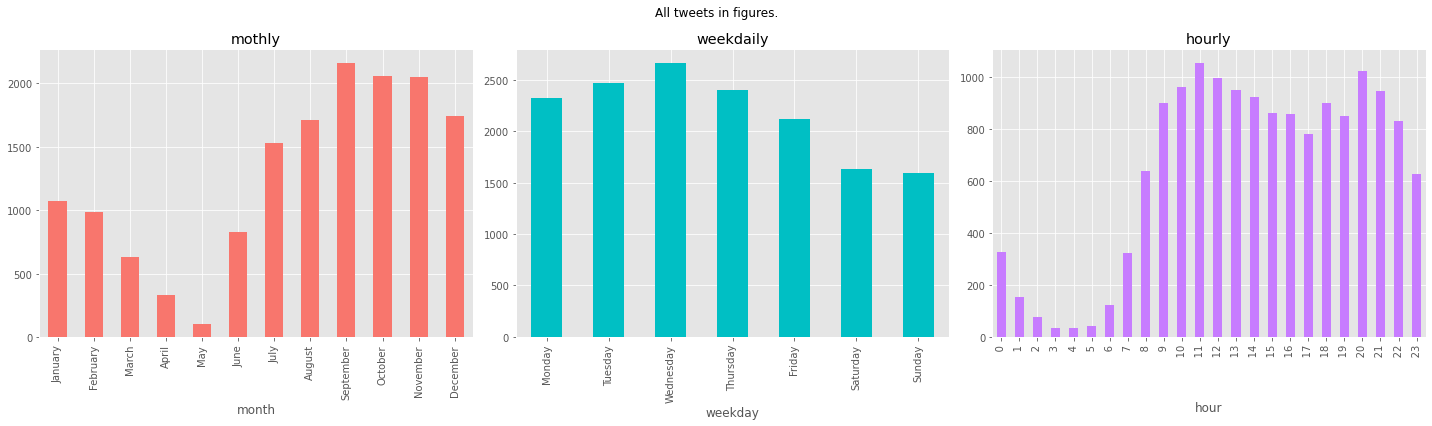

In [20]:
def tweet_count_bars(df_m, df_wd, df_h, title='All tweets in figures.'):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    df_m.plot(kind='bar', ax=ax[0], color='#f8766d')
    df_wd.plot(kind='bar', ax=ax[1], color='#00bfc4')
    df_h.plot(kind='bar', ax=ax[2], color='#c77cff')

    for i, t in zip(range(3), ['mothly', 'weekdaily', 'hourly']):
        ax[i].get_legend().remove()
        ax[i].set_title(t)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
tweet_count_bars(df_mc, df_wdc, df_hc)

1. Most of tweets have come from months: september, october and november and the least from may.
2. Most of the tweets have been posted on Wednesday and the least on Saturday and Sunday.
3. Most of the tweets have been written around the midday (hours 10-13) and in the evening (hours 20, 21).

## Timeline amounts
---

In [21]:
df_dc

,count
date,
2014-06-06,8.0
2014-06-07,6.0
2014-06-08,5.0
2014-06-09,12.0
2014-06-10,15.0
...,...
2016-11-07,35.0
2016-11-08,26.0
2016-11-09,26.0


In [22]:
# morphological closing operation of two-values list
# (p - positive element | n - negative element | threshold - min. empty space length)
def closing_empty_spaces(values, p=.0, n=None, threshold=10):
    es_b, positive = list([]), n
    for i, es in enumerate(values):
        # if currently is positive but previously was not
        if es == p and positive == n:
            es_b.append(i)
            positive = p
        # if currently is negative but previously was
        if es == n and positive == p:
            es_b.append(i)
            positive = n

    # if length of empty bound is less than threshold then remove it
    e = list(zip(es_b[::2], es_b[1::2]))
    e_accepted = list([])
    for e0, e1 in e:
        if e1-e0 < threshold:
            for i in range(e0, e1):
                values[i] = None
        else:
            e_accepted.append((e0, e1))
    return values, e_accepted

# highlight empty spaces in timeline dataframe
# (p - positive element | n - negative element | threshold - min. empty space length)
def find_empty_spaces(df_timeline, p=.0, n=None, threshold=10):
    df = pd.DataFrame(df_timeline.values, columns=df_timeline.columns, index=df_timeline.index)
    
    # find all positions with empty values and highlight them as .0 oppositely None
    empty_space = np.where(pd.isna(df['count']), .0, None)
    # reduce small empty spaces (with length under threshold)
    empty_space, empty_space_bounds = closing_empty_spaces(empty_space, p=.0, n=None,
                                                           threshold=threshold)
    df['empty space'] = empty_space
    
    return df, empty_space_bounds

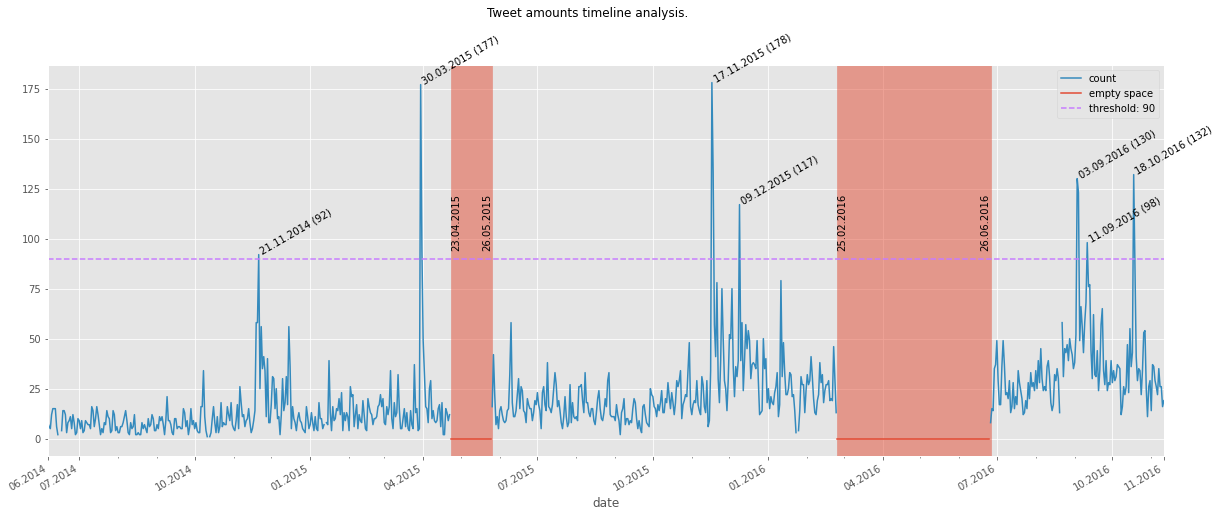

In [23]:
def tweets_timeline(df, empty_spaces=False, threshold=100, empty_space_threshold=10,
                    title='Tweet amounts timeline analysis.'):
    fig, ax = plt.subplots(figsize=(20, 8))

    # plot tweet amounts
    if empty_spaces:
        df, empty_spaces = find_empty_spaces(df, threshold=empty_space_threshold)
    df.plot(ax=ax, color=['#348abd', '#e24a33'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))
    fig.autofmt_xdate()

    # plot threshold line
    ax.axhline(threshold, label=f'threshold: {threshold}', color='#c77cff', linestyle='--')

    # annotate peaks above threshold
    peaks_ids, _ = find_peaks(df['count'].values, height=threshold)
    for p_id in peaks_ids:
        x = df.index[p_id]
        y = df['count'].values[p_id]
        ax.text(x, y, f'{datetime.strftime(x, "%d.%m.%Y")} ({int(y)})', rotation='30')
    
    # highlight empty spaces
    if empty_spaces:
        for es in empty_spaces:
            i = df.index[es[0]]
            j = df.index[es[1]]
            y_pos = (df['count'].max() - df['count'].min())//2
            ax.axvspan(i, j, alpha=0.5, color='#e24a33')
            ax.text(i, threshold+5, f'{datetime.strftime(i, "%d.%m.%Y")}', rotation='90')
            ax.text(j, threshold+5, f'{datetime.strftime(j, "%d.%m.%Y")}', rotation='90', ha='right')
    
    plt.legend(loc='best')
    plt.suptitle(title)
    plt.show()

tweets_timeline(df_dc, empty_spaces=True, threshold=90)

Some areas are empty due to the faulty mechanism of Twint scraper, i.e. faulty Internet connection. These will be filled after the best multi-label classification model will have been trained.

## Hate speech types analysis
---
* Monthly, weekdaily, hourly counts
* Timeline amounts (*have not been performed due to the lack of data*)

**Wyzywanie**

In [24]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='wyzywanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

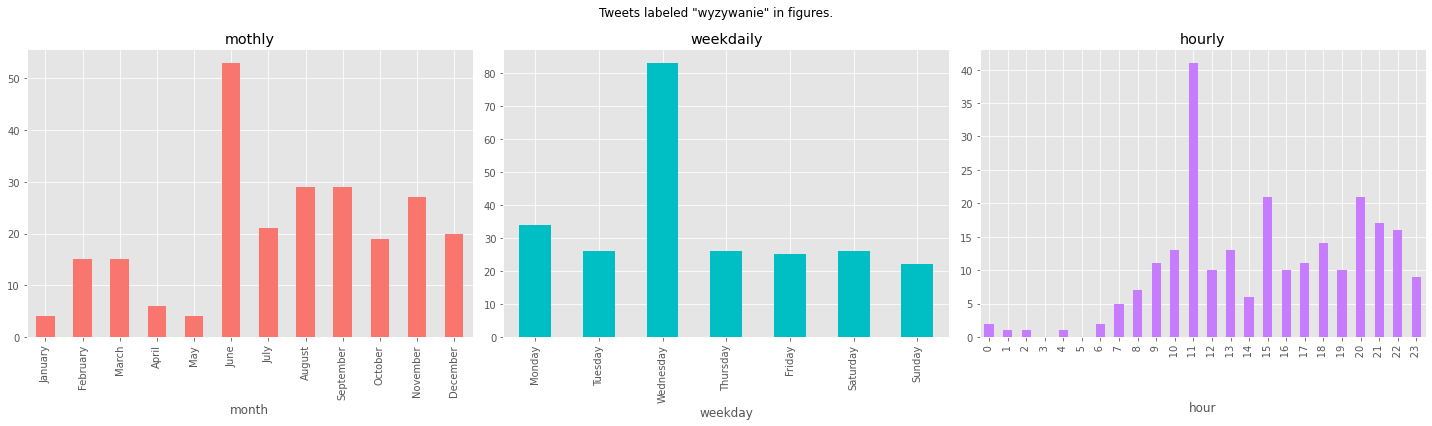

In [25]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "wyzywanie" in figures.')

**Grożenie**

In [26]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='grożenie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

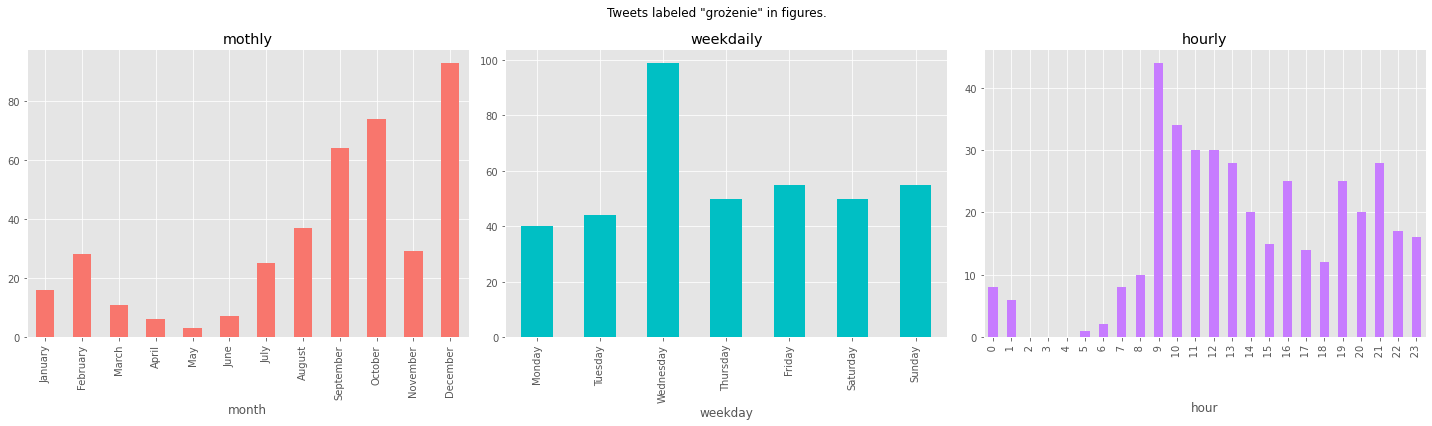

In [27]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "grożenie" in figures.')

**Wykluczanie**

In [28]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='wykluczanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

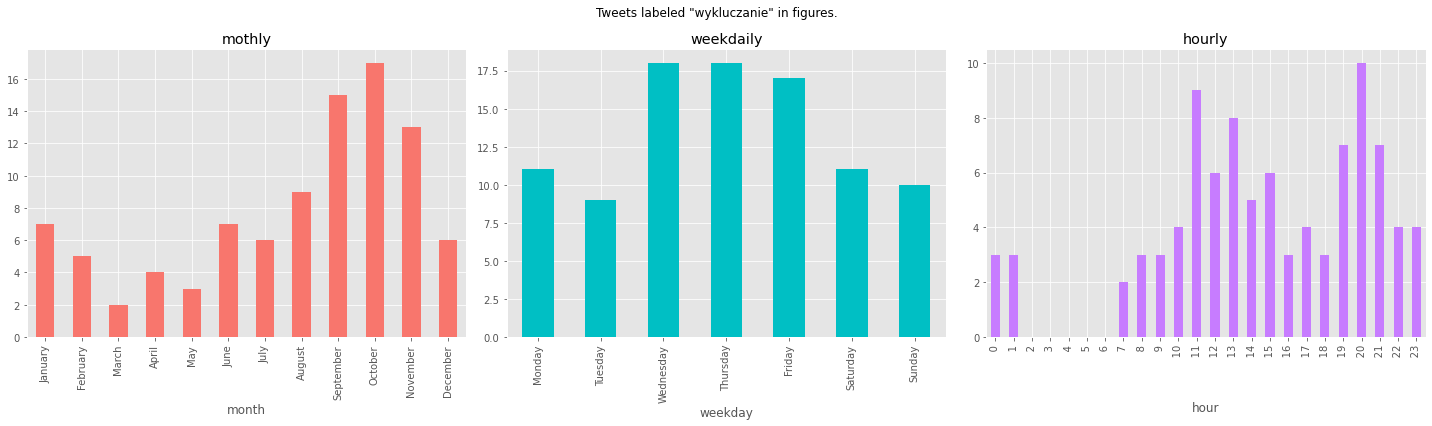

In [29]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "wykluczanie" in figures.')

**Odczłowieczanie**

In [30]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='odczłowieczanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

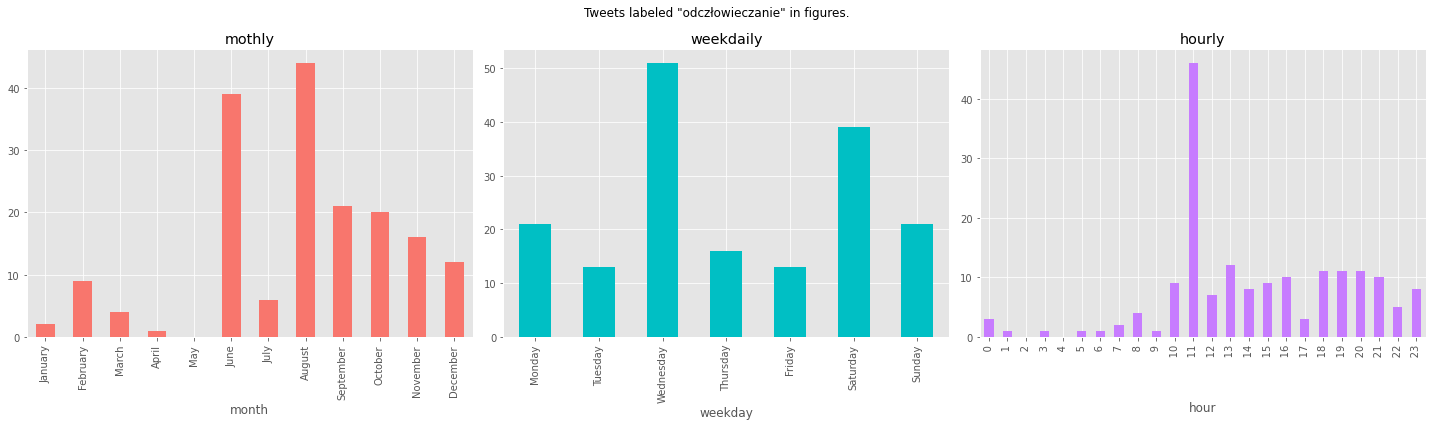

In [31]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "odczłowieczanie" in figures.')

**Poniżanie**

In [32]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='poniżanie',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

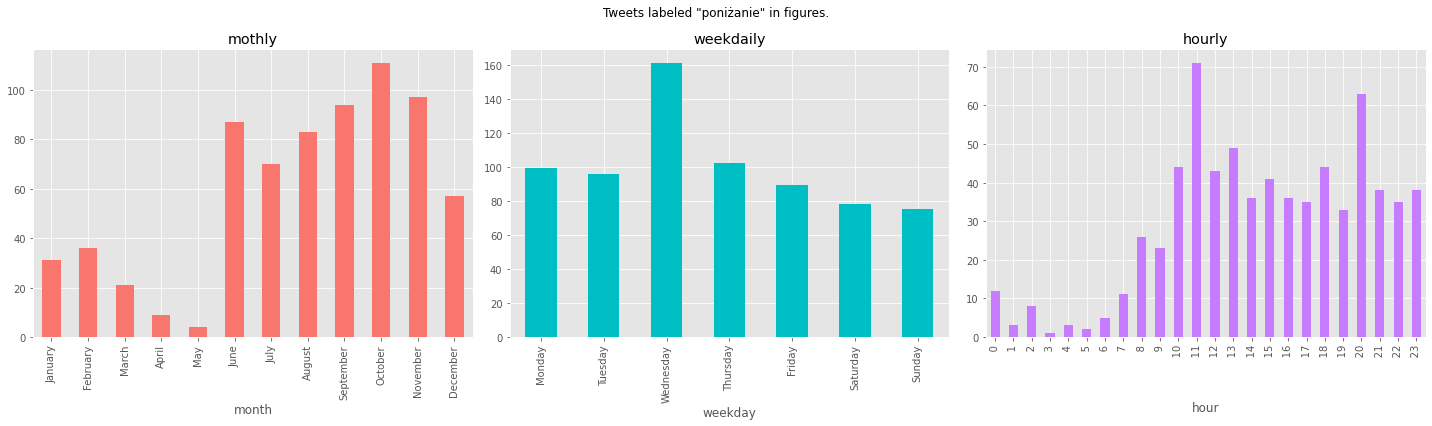

In [33]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "poniżanie" in figures.')

**Stygmatyzacja**

In [34]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='stygmatyzacja',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

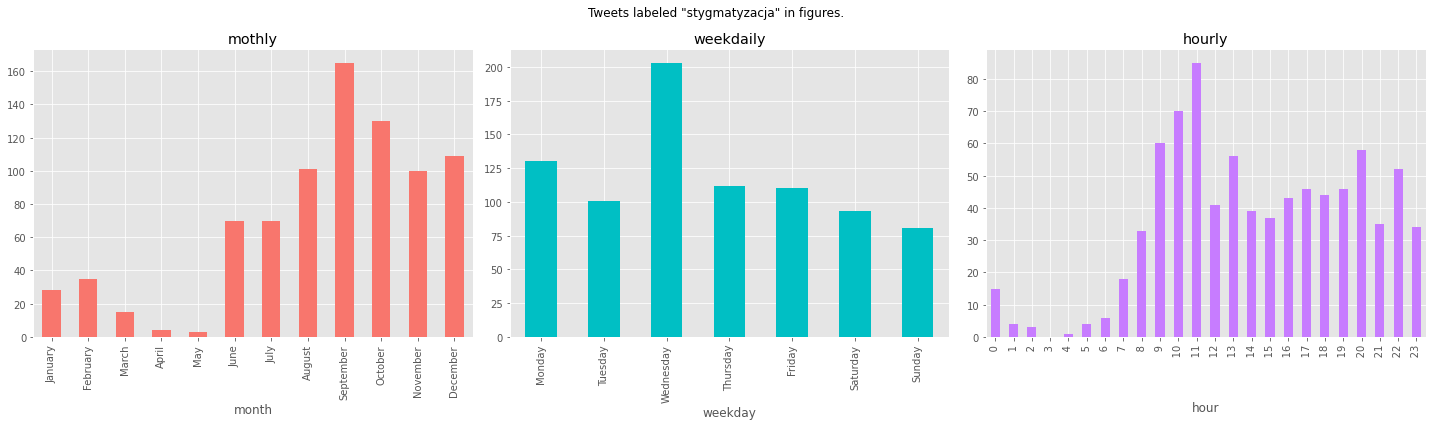

In [35]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "stygmatyzacja" in figures.')

**Szantaż**

In [36]:
df_yc, df_mc, df_wdc, df_hc, df_dc = get_stats(df_combined, hate_type='szantaż',
                                               month_names=MONTH_NAMES,
                                               weekday_names=WEEKDAY_NAMES)

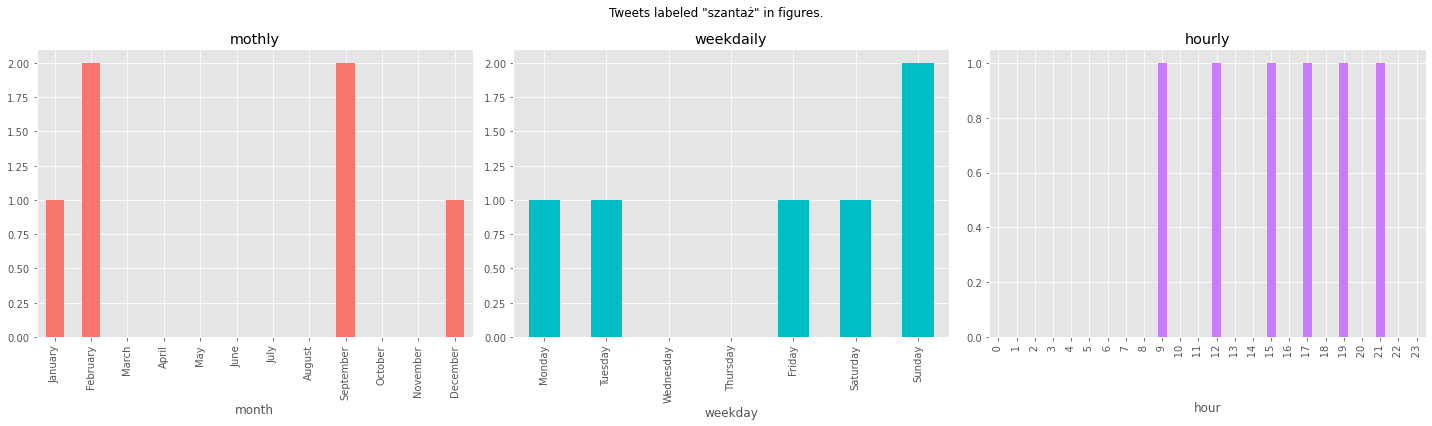

In [37]:
tweet_count_bars(df_mc, df_wdc, df_hc, title='Tweets labeled "szantaż" in figures.')